<b><font size='6'>Assignment 5<br>Churn Prediction with Spark MLlib</font></b>

**BDT ILV bds19: Big Data Technologien ILV**  
**Data Science & Business Analytics**

Author: Thomas Schrittwieser, DS191004  
Date: 2020-12-18

# Task

The goal of the assignment is to improve the existing churn prediction (AUC score: 0.67) using cleansing, feature engineering, different classification algorithm and/or hyperparameter optimization.

---

# Preprocessing

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col
import pyspark.sql.functions as F

from pyspark.ml import Pipeline

from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler, StandardScaler

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier

from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [2]:
# matplotlib styles
%matplotlib inline
plt.style.use('seaborn')

In [3]:
# dictionary for AUC-results
auc_scores_dict = {}

# set seed
SEED = 1234

In [4]:
# create sparkSession
spark = SparkSession.builder.appName('jupyter').getOrCreate()
#spark = SparkSession.builder.appName('jupyter').master('spark://hadoop.priebe.io:7077').getOrCreate()
#sc = spark.sparkContext

In [5]:
# read the dataset
df = spark.read.format('csv') \
    .option('header', 'true') \
    .option('inferSchema', 'true') \
    .load('hdfs://hadoop.priebe.io:9000/user/lbpriebe/churn/Customer_Churn.csv')

In [6]:
# Check the data validity using the statistical key figures
def statistical_boxplot(df, df_name):
    # df: Dataframe
    
    # generate a list with the names of all numeric columns
    num_columns = df.select_dtypes(include=np.number).columns.tolist()
    num_columns_len = len(num_columns)

    # marker for outliers
    red_square = dict(markerfacecolor='r', marker='s')

    # set counter
    cnt=0

    # draw boxplots
    suptitle_size = 16
    boxplottitle_size = 14
    plot_size = (num_columns_len*3, 8)
    
    fig, ax = plt.subplots(1, num_columns_len,figsize = plot_size)
    fig.suptitle(f'{df_name} - Boxplots of all numeric features', fontsize = suptitle_size)

    for i in num_columns:
        ax[cnt].boxplot(df[i], flierprops=red_square)
        ax[cnt].set_title(i, size=boxplottitle_size)
        ax[cnt].set(xticklabels=[])
        cnt+=1

# Exploratory Data Analysis

In [7]:
df.limit(5).toPandas()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
df.printSchema()

root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



## Checking NULL-values

In [9]:
# show NULL-values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Checking zero values

In [10]:
# checking 0-values
df_zero = df.select([F.count(F.when(df[c] == 0, c)).alias(c) for c in df.columns])
df_zero = df_zero.limit(1).toPandas()
df_zero

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,0,0,0,0,0,0,413,3617,0,2945,4849,0,7963


In [11]:
# calculate the the percentage of customers who did not provide a balance 
df_zero['Balance'][0]/df.count()

0.3617

More than 36% of all customers have not provided their balance. Therefore, this feature is dropped.

## Statistical Analysis

In [12]:
df.toPandas().describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


## Drop unnecessary features

In [13]:
# drop unnecessary columns
df = df.drop('RowNumber').drop('CustomerId').drop('Surname').drop('Balance')

## Feature Selection

In [14]:
# calculate Tenure/Age-Ratio
df = df.withColumn('TenureAgeRatio', col('Tenure') / col('Age'))

# calculate Balance/Salary-Ratio
#df = df.withColumn('BalanceSalaryRatio', col('Balance') / col('EstimatedSalary'))

#df.limit(5).toPandas()

## Boxplots

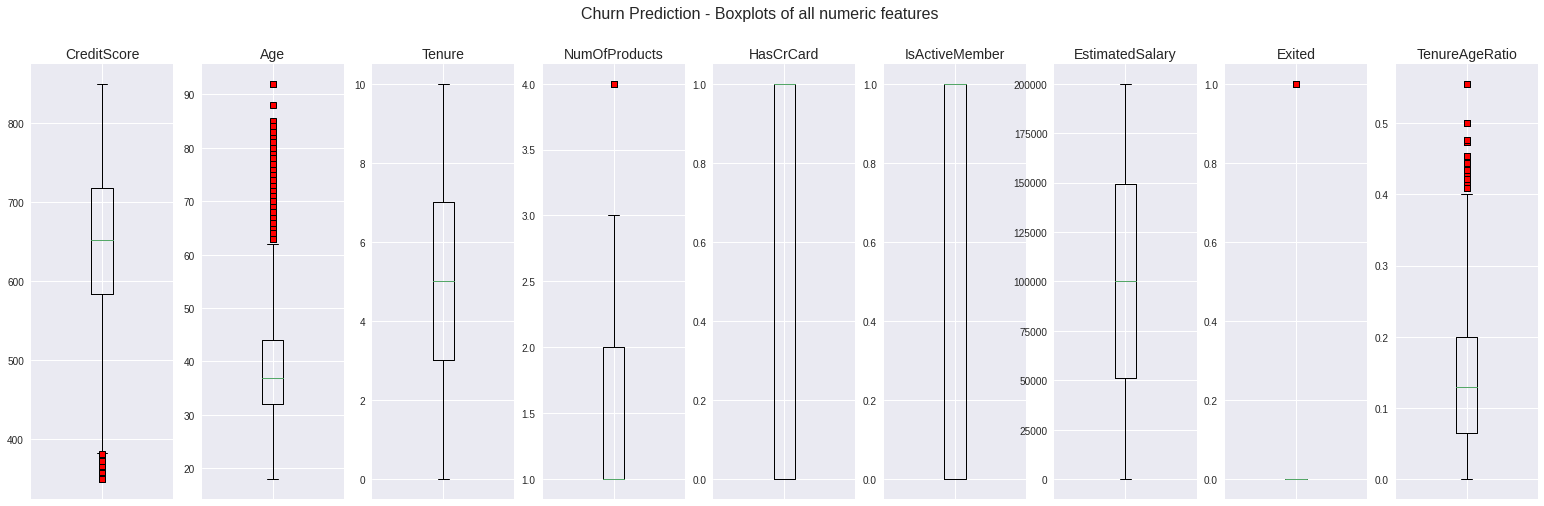

In [15]:
statistical_boxplot(df.toPandas(), 'Churn Prediction')

## Histogramm of all relevant features

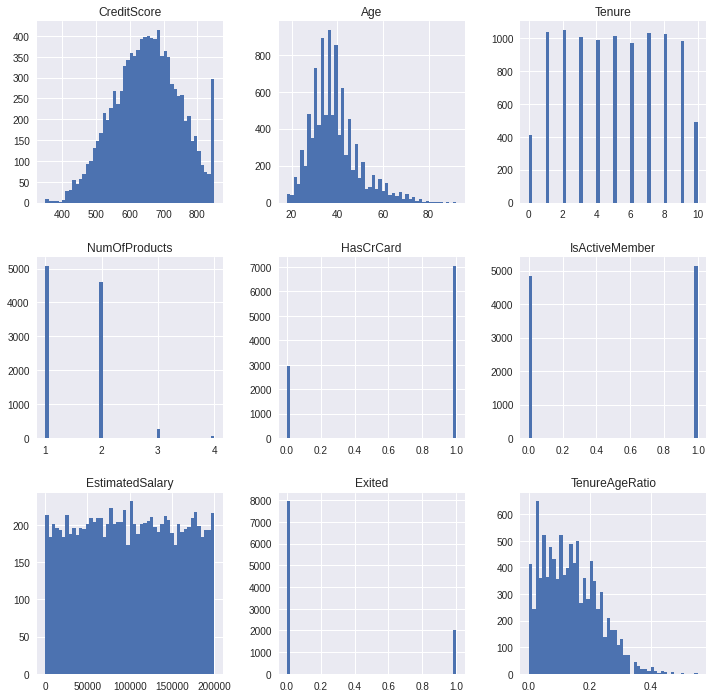

In [16]:
# histogramm of all relevant features
df.toPandas().hist(bins = 50, figsize=(12,12));

# Preprocessing for Classification

## Label Encoding

In [17]:
# label encoding for feature 'geography'
geographyIndexer = StringIndexer(inputCol='Geography', outputCol = 'Geography_idx')
geographyIndexerModel = geographyIndexer.fit(df)
df_le = geographyIndexerModel.transform(df)

# label encoding for feature 'geography'
genderIndexer = StringIndexer(inputCol='Gender', outputCol = 'Gender_idx')
genderIndexerModel = genderIndexer.fit(df_le)
df_le = genderIndexerModel.transform(df_le)

# drop unnessecary columns
df_le = df_le.drop('Geography').drop('Gender')

#df_le.limit(5).toPandas()

## OneHotEncoding

In [18]:
# onehotencoding for feature 'geography_idx'
genderEncoder = OneHotEncoder(inputCol='Geography_idx', outputCol='Geography_ohe', dropLast=False)
genderEncoderModel = genderEncoder.fit(df_le)
df_ohe = genderEncoderModel.transform(df_le)

# onehotencoding for feature 'gender_idx'
genderEncoder = OneHotEncoder(inputCol='Gender_idx', outputCol='Gender_ohe', dropLast=False)
genderEncoderModel = genderEncoder.fit(df_ohe)
df_ohe = genderEncoderModel.transform(df_ohe)

# drop unnecessary columns
df_ohe = df_ohe.drop('Geography_idx').drop('Gender_idx')

#df_ohe.limit(5).toPandas()

## Merging of multiple columns into a vector column

In [19]:
# merge multiple columns into a vector column
feature_cols = ['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'TenureAgeRatio', 'Geography_ohe', 'Gender_ohe']

assembler = VectorAssembler(inputCols=feature_cols, outputCol='Features')
df_va = assembler.transform(df_ohe)

df_va = df_va.select('Features', 'Exited')

#df_va.limit(5).toPandas()

## MinMax-Scaler

In [20]:
# define minmax-scaler
scaler = MinMaxScaler(inputCol='Features', outputCol='Features_minmax_scaled')

# compute summary statistics and generate MinMaxScalerModel
scalerModel = scaler.fit(df_va)

# rescale each feature to range [min, max].
df_minmax = scalerModel.transform(df_va)

# drop unnecessary features
df_minmax = df_minmax.drop('Features')

#df_minmax.limit(5).toPandas()

## Standard-Scaler

In [21]:
# define standard-scaler
scaler = StandardScaler(inputCol='Features', outputCol='Features_std_scaled', withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(df_va)

# Normalize each feature to have unit standard deviation.
df_std = scalerModel.transform(df_va)

# drop unnecessary features
df_std = df_std.drop('Features')

#df_std.limit(5).toPandas()

# Classification

## Logistic Regression with MinMax-Scaler

In [22]:
model_name = 'Logistic Regression (MinMax-Scaler)'

In [23]:
# train-test split
df_train, df_test = df_minmax.randomSplit([0.7, 0.3], seed=SEED)

In [24]:
# define model
lr = LogisticRegression(featuresCol='Features_minmax_scaled', labelCol='Exited')

# fit model
lr_model = lr.fit(df_train)

# evaluate model on test data
predictions = lr_model.transform(df_test)

#predictions.limit(5).toPandas()

In [25]:
evaluator = BinaryClassificationEvaluator(labelCol='Exited', metricName='areaUnderROC')

# add result to dict
auc_scores_dict[model_name] = evaluator.evaluate(predictions)

print(f'\n{model_name}:')
print(f'    *) AUC score: {evaluator.evaluate(predictions):.3}')


Logistic Regression (MinMax-Scaler):
    *) AUC score: 0.765


## Logistic Regression with Standard-Scaler

In [26]:
model_name = 'Logistic Regression (Standard-Scaler)'

In [27]:
# train-test split
df_train, df_test = df_std.randomSplit([0.7, 0.3], seed=SEED)

In [28]:
# define model
lr = LogisticRegression(featuresCol='Features_std_scaled', labelCol='Exited')

# fit model
lr_model = lr.fit(df_train)

# evaluate model on test data
predictions = lr_model.transform(df_test)

#predictions.limit(5).toPandas()

In [29]:
evaluator = BinaryClassificationEvaluator(labelCol='Exited', metricName='areaUnderROC')

# add result to dict
auc_scores_dict[model_name] = evaluator.evaluate(predictions)

print(f'\n{model_name}:')
print(f'    *) AUC score: {evaluator.evaluate(predictions):.3}')


Logistic Regression (Standard-Scaler):
    *) AUC score: 0.769


## Support Vector Classifier

In [30]:
model_name = 'Support Vector Classifier'

In [31]:
# train-test split
df_train, df_test = df_std.randomSplit([0.7, 0.3], seed=SEED)

In [32]:
# define model pipeline
svc = LinearSVC(featuresCol='Features_std_scaled', labelCol='Exited', maxIter=100)
svc_pipeline = Pipeline(stages = [svc])

In [33]:
# define model parameter grid
svc_grid = ParamGridBuilder() \
    .addGrid(svc.standardization, [False]) \
    .addGrid(svc.regParam, [1e-1, 1e-2, 1e-3]) \
    .addGrid(svc.tol, [1e-2, 1e-3, 1e-4]) \
    .addGrid(svc.threshold, [0]) \
    .addGrid(svc.aggregationDepth, [2,3,4]) \
    .build()

In [34]:
# define evaluator
evaluator = BinaryClassificationEvaluator(labelCol = 'Exited', metricName = 'areaUnderROC')

In [35]:
# define 5-fold cross-validation
crossval = CrossValidator(
    estimator = svc_pipeline,
    estimatorParamMaps = svc_grid,
    evaluator = evaluator,
    numFolds = 5
    )

In [36]:
%%time
#fit model
svc_model = crossval.fit(df_train)

CPU times: user 6.91 s, sys: 1.38 s, total: 8.29 s
Wall time: 9min 37s


In [37]:
# evaluate model on test data
predictions = svc_model.transform(df_test)

# add result to dict
auc_scores_dict[model_name] = evaluator.evaluate(predictions)

print(f'\n{model_name}:')
print(f'    *) AUC score: {evaluator.evaluate(predictions):.3}')


Support Vector Classifier:
    *) AUC score: 0.769


## Gradient-Boosted Tree Classifier

In [38]:
model_name = 'Gradient-Boosted Tree Classifier'

In [39]:
# train-test split
df_train, df_test = df_va.randomSplit([0.7, 0.3], seed=SEED)

In [40]:
# define model pipeline
gbt = GBTClassifier(featuresCol='Features', labelCol='Exited', maxIter=100, seed= SEED)
gbt_pipeline = Pipeline(stages = [gbt])

In [41]:
# define model parameter grid
gbt_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5]) \
    .addGrid(gbt.maxIter, [10, 20, 30]) \
    .addGrid(gbt.maxBins, [16, 32]) \
    .build()

In [42]:
# define evaluator
evaluator = BinaryClassificationEvaluator(labelCol = 'Exited', metricName = 'areaUnderROC')

In [43]:
# define 5-fold cross-validation
crossval = CrossValidator(
    estimator = gbt_pipeline,
    estimatorParamMaps = gbt_grid,
    evaluator = evaluator,
    numFolds = 5
    )

In [44]:
%%time
#fit model
gbt_model = crossval.fit(df_train)

CPU times: user 4.68 s, sys: 1.14 s, total: 5.82 s
Wall time: 8min 12s


In [45]:
# evaluate model on test data
predictions = gbt_model.transform(df_test)

# add result to dict
auc_scores_dict[model_name] = evaluator.evaluate(predictions)

print(f'\n{model_name}:')
print(f'    *) AUC score: {evaluator.evaluate(predictions):.3}')


Gradient-Boosted Tree Classifier:
    *) AUC score: 0.838


## Random Forest

In [46]:
model_name = 'Random Forest'

In [47]:
# train-test split
df_train, df_test = df_va.randomSplit([0.7, 0.3], seed=SEED)

In [48]:
# define model pipeline
rf = RandomForestClassifier(featuresCol='Features', labelCol='Exited', seed=SEED)
rf_pipeline = Pipeline(stages = [rf])

In [49]:
# define model parameter grid
rf_grid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [3, 5]) \
    .addGrid(rf.maxBins, [16, 32]) \
    .build()

In [50]:
# define model parameter grid
rf_grid = ParamGridBuilder() \
    .build()

In [51]:
# define evaluator
evaluator = BinaryClassificationEvaluator(labelCol = 'Exited', metricName = 'areaUnderROC')

In [52]:
# define 5-fold cross-validation
crossval = CrossValidator(
    estimator = rf_pipeline,
    estimatorParamMaps = rf_grid,
    evaluator = evaluator,
    numFolds = 5
    )

In [53]:
%%time
#fit model
rf_model = crossval.fit(df_train)

CPU times: user 249 ms, sys: 61.3 ms, total: 310 ms
Wall time: 8.14 s


In [54]:
# evaluate model on test data
predictions = rf_model.transform(df_test)

# add result to dict
auc_scores_dict[model_name] = evaluator.evaluate(predictions)

print(f'\n{model_name}:')
print(f'    *) AUC score: {evaluator.evaluate(predictions):.3}')


Random Forest:
    *) AUC score: 0.818


# Results

In [59]:
for key, value in auc_scores_dict.items():
    print(f'{key}: {round(value,3)}')

Logistic Regression (MinMax-Scaler): 0.765
Logistic Regression (Standard-Scaler): 0.769
Support Vector Classifier: 0.769
Gradient-Boosted Tree Classifier: 0.838
Random Forest: 0.818


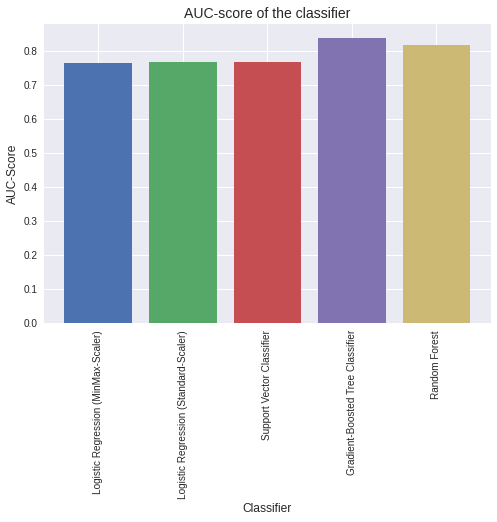

In [76]:
for key, value in auc_scores_dict.items():
    plt.bar(x = key, height=value)
plt.title('AUC-score of the classifier', fontsize=14)
plt.xlabel('Classifier', fontsize=12)
plt.ylabel('AUC-Score', fontsize=12)
plt.tick_params(axis='x', labelrotation=90);

The best results were obtained with ensemble classifiers. The top performer is a Gradient-Boosting Tree Classifier, followed by a random forest.